# An Overview of Attention Is All You Need

About a year ago now a paper called [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf) (in this post sometimes referred to as simply "the paper") introduced an architecture called the Transformer model for sequence to sequence problems that achieved state of the art results in machine translation. The name of the paper is taken from the approach of building a model that leverages the widely successful attention mechanism within a more traditional "feed forward" framework without using recurrence or convolutions.

Since its introduction slight variations of the Transformer have been applied to a variety of problems, see [here](https://github.com/tensorflow/tensor2tensor), outside of machine translation such as image classification, text summarization, speech recognition and even [generating fake wikipedia articles](https://www.youtube.com/watch?v=rBCqOTEfxvg).

In this post we'll survey the key elements of the Transformer model and training one end to end. In a follow up post I'll walk through a `keras` implementation of the Transformer model (as of this writing the implementation is about 95% complete, however if you're curious you can find the implementation [here](https://github.com/dantegates/attention-is-all-you-need) on my GitHub account in the mean time).

# Preliminaries

Before going in depth, let's cover some preliminaries. If you are unfamiliar with the topics covered here you may want to do some additional research before continuing.

**Sequence to sequence (seq2seq)**: Seq2seq models map input of an arbitrary length to an output of arbitrary length. This is different from the conventional notion of machine learning models which are trained on a feature space of *fixed* dimmension to predict an output of *fixed* dimmension. A positive example is translating sentences from English to French where both the input and output sentence could be of any length. As a negative example consider the [keras MNIST tutorial](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py) which is typical of most machine learning models. This example classifies an image as one of **10** categories given the **784** pixels of the image. The traditional approach is a natural fit for many applications but for tasks such as machine translation seq2seq models are more intuitive.

**Recurrent Neural Networks (RNNs)**: We won't discuss RNNs in much detail in this post. However to appreciate the Transformer model you should understand that RNNs, such as [LSTMs](https://en.wikipedia.org/wiki/Long_short-term_memory), have been the leaders in the seq2seq space for a while. However, they have some limitations which are discussed in more detail in Attention Is All You Need.

**Convolutional Neural Networks (CNNs)**: One typically thinks of convolutional neural networks in the context of images. However convolutional networks such as [ByteNet](https://arxiv.org/pdf/1610.10099.pdf) or [WaveNet](hhttps://arxiv.org/pdf/1609.03499.pdf) were introduced to handle sequences by restricting the convolutions from "looking forward". As with RNNs we won't discuss this in detail and it's not important for understanding the Transformer but it is worth noting that the Transformer is copared against convolutional networks for sequences in Attention Is All You Need.

**Encoder/decoder**: Encoder/decoder architectures refer to models with two components. The *encoder* creates a latent representation of the input. The *decoder* then maps this latent representation to the final prediction. This type of architecture is usually seen in RNNs (the encoding is the hidden state of the RNN and a decoder uses this hidden state to make a final prediction), however we'll see this is also a key element of the Transformer model.

**Attention**: Attention can be understood in two ways. First, heuristically. Attention is something we apply to seq2seq models. The motivation is that some word(s) in "Hello how are you?" is/are more important than others to predict that "Hola" should appear as the first word in the corresponding Spanish translation. Attention is a learned mechanism that allows the model to pay attention to words that are more relevant than others. Second we can understand attention mathematically which we'll discuss this more below.

**Auto regressive**: In the most general sense an [autoregressive models](https://en.wikipedia.org/wiki/Autoregressive_model) predict sequences where each new prediction depends on predictions of previous steps. In NLP this usually means that we predict one token of the output at a time given some input and the tokens previously predicted. keras has a pretty good [tutorial](https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html) that describes this process. This pattern is seen in RNNs and the Transformer follows suit.

# The Transformer at a High Level

Now that we've covered the preliminaries we can discuss the Transformer at a high level.

At a high level, the Transformer model follows the encoder/decoder pattern mapping two input matrices (each containing sequences of word embeddings) of shape $n\times d_{model}$ to a matrix of shape $n\times\text{vocab size}$ where $n$ is the sequence size. The Transformer is a true seq2seq model and therefore $n$ is not fixed but determined by the length of the sequence(s) at hand.

The Transformer makes predictions without recurrence or convolutions and rather stacks dense layers seen in traditional deep neural networks with an attention mechanism as the activation function of certain layers. In particular the Transformer makes use of something known as "multi-head attention". While multi-head attention was not introduced by this model, it was by one of the authors of Attention Is All You Need and improved on in the Transformer.

The Transformer incorporates the usual NLP tricks along with various state of the art techniques all into one architecture. Examples include word embeddings, residual connections, layer normalization, learning rate scheduling and byte pair encoding.

# Data processing

## Byte Pair Encoding

First, let's cover the data processing used in the paper - Byte Pair Encoding or BPE.

BPE is a particular implementation of the more general notion of [subword units](http://www.aclweb.org/anthology/P16-1162), a simple but powerful idea.

Subword units is based on the intuition that pieces of a word may generalize better in machine translation than the entire word itself. As a simple example we can see that the subword units `["pre", "determine", "d"]` together carry all of the information required to express the word `"predetermined"`, but some additional information as well that may be useful for generalization.

BPE is essentially a greedy algorithm that learns the optimal subword units needed to tokenize a given corpus given a constraint on the number of subword units it must learn. The paper above gives the following example. Given the corpus `["low", "lowest", "newer", "wider"]` BPE would learn to tokenize `"lower"` as `["low", "er"]`.

This brings us to the advantages of BPE. Namely Subword units frees machine translation models of restrictions imposed by learning from a fixed dictionary. Notice in the example above `"lower"` was tokenized in a meaningful way but was not part of the training corpus. This is distinguished from the paradigm where a model is trained on a fixed dictionary of the top $N$ most popular words.

Not only does this reduce the number of out of vocabulary tokens required at train time, it also introduces the possibility of correctly predicting words *not seen* at train time by predicting the correct subword units.

# Architecture

Caveat: The Transformer makes use of many ideas that could be covered in an entire post themselves, such as [Residual Connections](https://arxiv.org/pdf/1512.03385.pdf) and [Layer Normalization](https://arxiv.org/pdf/1607.06450.pdf). To keep this post brief I'm going to focus mainly on the Attention component of the Transformer model. However I will highlight the key aspects of the model's architecture even if I don't cover each piece in depth.

## Encoder/Decoder

As mentioned above the transformer follows the encoder/decoder pattern. This is explained best with the following picture from the paper.

<img src="./static/transformer-architecture.png" alt="drawing" width="400px"/>

Here the left side is the encoder and the right side is the decoder. In the case of translation the input to the encoder is the sentence to translate (technically the sentence converted to a sequence of word vectors) and the input to the decoder is the target sentence (shifted right by one token, this is covered more in the section on Masking).

As we can see from the picture the encoding is brought into the middle of the decoder. The final output of the decoder is a sequence of softmax probabilities for each token in the translated sentence.

## Embeddings

Like many approaches to NLP the first step of the Transformer is to convert the sequences of tokens to learned word embeddings. The dimmension of the embeddings is referred to as $d_{model}$ in the Attention Is All You Need paper but you may see this referred to as the "hidden size" elsewhere, e.g. [in tensor2tensor](https://github.com/tensorflow/tensor2tensor/blob/342e214dea360a7f472fc82f3dd0775d7e224c52/tensor2tensor/models/transformer.py#L1474). In the paper $d_{model}=512$.

Keep in mind that the output of the embedding layers is a matrix in $R^{n\times d_{model}}$, where $n$ is the sequence length. This is straightforward but will come up again.

## Positional Encodings

We've mentioned before that intuitively, order matters in seq2seq models, something explicitly accounted for in RNNs by design.

To account for word order (or position) the Transformer adds a "positional encoding" to the word embeddings.

As pointed out in the paper there are several positional encoding schemes to choose from, however the Transformer employs the following.

$$
\begin{align*}
& PE_{pos, 2i}=sin(pos/10000^{2i/d_{model}}) \\
& PE_{pos, 2i+1}=cos(pos/10000^{2i/d_{model}})
\end{align*}
$$

The authors also point out that learned positional embeddings performed just as well, however this particular scheme should allow the model to generalize to sequences of greater length than seen at train time.

# Attention

Now we can break into talking about attention. After running the encoder/decoder inputs through an embedding layer and positional encoding both components of the model consist of a stack of identical layers (although these layers differ for the encoder and decoder as seen in the picture above).

Each layer consists of what the paper describes as "sublayers". This is where attention becomes a key component of the model.

If you are unfamiliar with attention keep in mind that during this discussion we'll assume certain details that are true of the Transformer, but not necessarily every implementation of attention (such as additive vs. multiplicative attention).

The authors of Attention Is All You Need describe attention as follows "An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors" - which isn't super helpful as it basically just tells us that the attention function is indeed a function and its input is three vectors.

Let's take a look at this a little closer.

Copying the notation from the paper we can represent attention mathematically as

$$
\text{Attention}(Q, K, V) = \text{softmax}(\frac{QK^{T}}{\sqrt{d_{k}}})V
$$

where $K\in R^{d_{k}}$.

Let's break this down a bit, ignoring the normalization factor $\sqrt{d_{k}}$ (which is simply an artifact to help the model converge during training - see the paper for details).

The argument to the softmax function can be seen as a similarity matrix of $Q$ and $K$ (think of [this](https://en.wikipedia.org/wiki/Euclidean_vector#Dot_product)). Usually we use the softmax function to represent class probabilities, but in this case we can think of the output of the softmax functions as weights that get applied the values of $V$, where the values of $V$ are amplified corresponding to the positions where $Q$ was most similar to $K$.

In practice we want to compute the attention function over many "queries", "keys" and "values" and for efficiency $Q$, $K$ and $V$ are matrices when we implement this.

For simplicity however, we can look at an example of the attention function computed on a single "query" against several "keys" and "values".

Remember that the rows in this example would be word vectors in the Transformer model.

In [150]:
import numpy as np
Q = np.array([[-1, 6, 3]])
K = V = np.array([
    [-1.0,  6.0, 3.2],  # Q is most similar to first two rows
    [-1.1,  6.3, 2.5],  # these values will dominate the product softmax(.) V
    [ 6.0, -1.0, 3.0],
    [10.1,  0.0, 0.0],
])
def softmax(z): 
    max_z = np.max(z, axis=1).reshape(-1, 1)
    exp_z = np.exp(z - max_z)
    return exp_z / np.sum(exp_z, axis=1).reshape(-1, 1)
sigma = softmax(Q.dot(K.T))
sigma

array([[5.49833997e-01, 4.50166003e-01, 1.58206851e-22, 1.30537252e-25]])

In [151]:
sigma.dot(V)

array([[-1.0450166,  6.1350498,  2.8848838]])

## Multi-head Attention

Now that we've covered the attention mechanism itself let's discuss how it's actually implemented in the Transformer as "multi-head" attention.

Given three matrices $Q$, $K$ and $V$, multi-head attention is simply the concatenation of several attention heads. What is an attention head? Simply this, an attention head learns three weight matrices that project $Q$, $K$ and $V$ into the spaces $\mathbb{R}^{d_{model}\times d_{k}}$, $\mathbb{R}^{d_{model}\times d_{k}}$ and $\mathbb{R}^{d_{model}\times d_{v}}$ and computes attention on the projections.

Copying the notation from the paper,  multi-head attention is defined as

$$
\text{MultiHead}(Q,K,V)=\text{concat}(head_{1},\dots,head_{n}) \\
\text{where }head_{i}=\text{attention}(QW_{i}^{Q}, KW_{i}^{K}, VW_{i}^{V})
$$

In [my keras implementation](https://github.com/dantegates/attention-is-all-you-need) of the transformer multi-head attention is implemented (roughly) with two classes as follows

```python
class MultiHeadAttention(Layer):
    def __init__(self, n_heads, d_model, d_k, d_v, masking=False, **kwargs):
        # activation = comparison
        logger.debug('init MultiHeadAttention')
        assert d_model % n_heads == 0, 'h must divide d_model evenly'
        self.n_heads = n_heads
        self.d_model = d_model
        self.d_k = self.d_model // n_heads if d_k is None else d_k
        self.d_v = self.d_model // n_heads if d_v is None else d_v
        self.masking = masking
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        if isinstance(input_shape, list):
            assert len(set(input_shape)) == 1, 'k, q, and v must be of same shape'
            shape = input_shape[0]
        else:
            shape = input_shape
        logger.debug('building MultiAttention')
        self.W_o = self.add_weight(name='W_o', 
                                   shape=(self.n_heads*self.d_v, self.d_model),
                                   initializer='uniform',
                                   trainable=True)
        self.heads = [AttentionHead(d_model=self.d_model, d_k=self.d_k, d_v=self.d_v, activation='softmax')
                      for _ in range(self.n_heads)]
        super().build(input_shape)
    
    # this signature is a hack to work with keras layers call only adding
    # a single position tensor to the graph (causes problems in encoder-decoder
    # attention)
    def call(self, inputs):
        concat = K.concatenate([head(inputs, masking=self.masking) for head in self.heads])
        logger.debug('concat shape: %s', K.int_shape(concat))
        return K.dot(concat, self.W_o)

    def compute_output_shape(self, input_shape):
        ...
```
```python
class AttentionHead(Layer):
    def __init__(self, d_model, d_k, d_v, activation, **kwargs):
        logger.debug('init AttentionHead') 
        self.d_model = d_model
        self.d_k = d_k
        self.d_v = d_v
        self.scalar = np.sqrt(self.d_k)
        self._activation = activation
        self.activation = activations.get(activation)
        super().__init__(**kwargs)

    def build(self, input_shape):
        if isinstance(input_shape, list):
            assert len(set(input_shape)) == 1, 'k, q, and v must be of same shape'
            shape = input_shape[0]
        else:
            shape = input_shape
        self.W_q = self.add_weight(name='W_q',
                                   shape=(shape[-1], self.d_k),
                                   initializer=RandomNormal(mean=0.0, stddev=1.0),
                                   trainable=True)
        self.W_k = self.add_weight(name='W_k',
                                   shape=(shape[-1], self.d_k),
                                   initializer=RandomNormal(mean=0.0, stddev=1.0),
                                   trainable=True)
        self.W_v = self.add_weight(name='W_v',
                                   shape=(shape[-1], self.d_v),
                                   initializer=RandomNormal(mean=0.0, stddev=1.0),
                                   trainable=True)
        super().build(input_shape)

    def call(self, inputs, masking=False):
        try:
            q, k, v = inputs
        except TypeError:
            q = k = v = inputs
        q_p = K.dot(q, self.W_q)
        k_p = K.dot(k, self.W_k)
        v_p = K.dot(v, self.W_v)
        k_t = K.permute_dimensions(K.transpose(k_p), (2, 0, 1))
        attention_weights = K.batch_dot(q_p, k_t) / K.variable(self.scalar)
        if masking:
            logger.debug('masking')
            attention_weights = self.mask(attention_weights)
        x = self.activation(attention_weights)
        return K.batch_dot(x, v_p)

    def mask(self, x):
        shape = K.int_shape(x)
        assert shape[1] == shape[2], 'expected square matrix'
        mask = np.zeros((shape[1], shape[1]))
        invalid_indices = np.triu_indices(shape[1], 1)
        mask[invalid_indices] = 1e-15
        mask = K.variable(mask)
        return x + mask

    def compute_output_shape(self, input_shape):
        ...
```

## Self-attention

Now we understand multi-head attention. Great. But how does it fit into the Transformer again?

Multi-head attention fits into the transformer as follows. *In the encoder* and the *first sublayer of the decoder* the Transformer applies something called self-attention. That is $Q=K=V$ which in this case happens to be the encoder/decoder inputs - sequences of word vectors of shape $n\times d_{model}$.

In the *second sublayer of the decoder* $Q=K=\text{encoder output}$ and $V=\text{output of decoder sublayer 1}$.

## Masking

Remember above how we noted that the Transformer is an autoregressive model? This has implications for how we implement self-attention in the decoder.

At train time we know all tokens of the target sequence. However at run time we only know the tokens of the target sequence that we have already generated. This means that if we aren't careful with how we implement the product $QK$ information from later tokens in the sequence will "leak" into earlier positions. To prevent this from happening we mask $K$ by setting all values above the diagonal to a really small number - which pushes the corresponding dot products to 0 in the softmax.

# Other techniques used in the architecture

## Residual Connections

The Transformer makes use of residual connections. That is, the input of each sublayer is added to the output of the multi-attention-head or feed forward network. As mentioned above this is a topic that deserves its own comprehensive treatment. For more details see https://arxiv.org/pdf/1512.03385.pdf and https://arxiv.org/pdf/1603.05027.pdf. One key thing to know about residual connections however is that they help combat the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem).

## Layer normalization

[Batch normalization](https://arxiv.org/pdf/1502.03167.pdf) is a method that has been shown to significantly decrease the amount of time needed during training for deep neural networks to converge. The name of the method is self explanatory. To implement batch normalization one simply normalizes each batch by substracting of the mean value of the batch and dividing by the variance (additionally learned "gain" and "bias" parameters are applied to each batch). This prevents what is known as "internal covariate shift"

Layer normalization was introduced as an improvement to batch normalization, namely it could be applied to RNNs and 
https://arxiv.org/pdf/1607.06450.pdf

# Training

## Batches

Training batches for the Transformer are constructed as follows

- Training examples (sentences for translation) are "batched" together according to the number of tokens in each sentence.
- From these "batches" training "steps" are constructed by grouping examples together to reach an approximate number of tokens desired per step - this is a shift from the typical notion when training on features of fixed dimmension where batches contain a *fixed* number of examples.

It is important to take note of the following details.
1. A gradient update is performed at each "step" - thus in this case what the paper refers to as training steps is more similar to a training batch in other contexts. Indeed, even in the tensor2tensor [source](https://github.com/tensorflow/tensor2tensor/blob/342e214dea360a7f472fc82f3dd0775d7e224c52/tensor2tensor/layers/common_hparams.py#L34) the word "batch_size" is used to describe what would be called a "step" size in the paper.
2. Constructing training steps from batches of sentences of approximately equal length minimizes (and in some steps may even eliminate) the amount of padding needed at train time.

## Learning rate

During training the learning rate of the optimizer (specifically Adam in the paper) varies at each step (see discussion on batches above), according to the paper the schedule "[increases] the learning rate linearly for the first *warmup_steps* and [decreases] it thereafter proportionally to the inverse square root of the step number." The following code shows how the learning rate is calculated using the default values from the paper and plots the schedule.

In [64]:
import matplotlib.pyplot as plt
import numpy as np

@np.vectorize
def lr_schedule(step_number, d_model, warmup_steps):
    return d_model**-0.5 * min(step_number**-0.5, step_number*warmup_steps**-1.5)

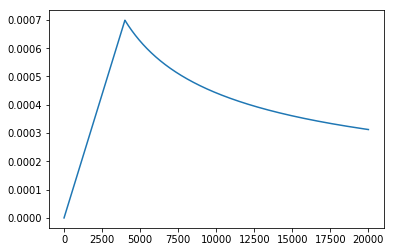

In [65]:
plt.plot(lr_schedule(np.arange(1, 20_000), d_model=512, warmup_steps=4000))

Note that the learning rate is determined by

- The value $d_{model}$
- The number of batches previously trained on
- The number of warmup batches chosen

The purpose of including $d_{model}$, rather the simply number of steps, is to define a learning rate schedule as a function of the model size so that a single formula can be used for models of all sizes without the need to tune additional parameters in the scheduler. I'd like to include a reference here but I cannot remember where I came accross this - it was either in a comment burried somewhere in the tensor2tensor source or the youtube link referenced above.

## Label smoothing